In [160]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

In [161]:
files = {
    "QB": "../data/qb_udk.csv",
    "RB": "../data/rb_udk.csv",
    "WR": "../data/wr_udk.csv",
    "TE": "../data/te_udk.csv",
}
data = None
for position in files:
    file = files[position]

    tmp_dataframe = pd.read_csv(file)
    tmp_dataframe['position'] = position

    if data is None:
        data = tmp_dataframe
    else:
        data = pd.concat((data, tmp_dataframe), axis=0)

data.columns = data.columns.str.lower()

data.reset_index(drop=True, inplace=True)
data['$'] = data['$'].str.replace('$', '')
data['$'] = data['$'].astype(int)
data.drop(['dynasty', 'markers', 'bye week'], axis=1, inplace=True)
data['risk'] = (data['risk'] - data['risk'].min()) / (data['risk'].max() - data['risk'].min())  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      259 non-null    object 
 1   team      259 non-null    object 
 2   rank      259 non-null    int64  
 3   $         259 non-null    int64  
 4   points    259 non-null    float64
 5   risk      259 non-null    float64
 6   tier      259 non-null    int64  
 7   outlook   259 non-null    object 
 8   position  259 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 18.3+ KB


/var/folders/wk/7_jgt9ms2vv7jzkq_hkgjv1h0000gn/T/ipykernel_2908/1735239172.py:22: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [162]:
keepers = [
    'Josh Allen',
    'Jonathan Taylor',
    'Derrick Henry',
    'Joe Mixon',
    'Leonard Fournette',
    "D'Andre Swift",
    'James Conner',
    'Cooper Kupp',
    'Justin Jefferson',
    'Stefon Diggs',
    'CeeDee Lamb',
    'Deebo Samuel',
    'Tee Higgins',
    'Marquise Brown',
    "Ja'Marr Chase",
    'Mark Andrews',
    'Michael Pittman Jr.',   
]

assert data[data['name'].isin(keepers)].count()[0] == len(keepers)

In [163]:
budget = 200
draft_picks = [
    {"name": "Najee Harris", "$": 55},
    {"name": "Cordarrelle Patterson", "$": 5}
]

for pick in draft_picks:
    budget -= pick['$']
    data = data[~data['name'].isin([pick['name']])]

data = data[~data['name'].isin(keepers)]
print(f'Remaining Budget: {budget}')

Remaining Budget: 140


In [164]:
roster_spots = {
    "QB": {
        "min": 1,
        "max": 2
    },
    "RB": {
        "min": 2,
        "max": 7
    },
    "WR": {
        "min": 2,
        "max": 7
    },
    "TE": {
        "min": 1,
        "max": 1
    },
    "ActiveSpots": 14,
    "IrSpots": 1
}

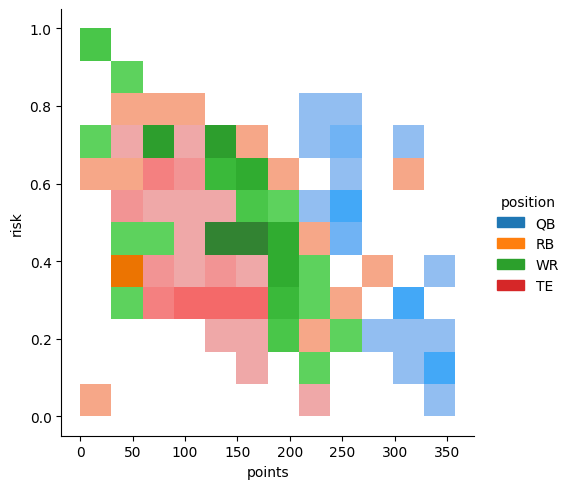

In [165]:
sns.displot(data=data, hue="position", x="points", y='risk', )

In [166]:
corr = round(data.corr(), 4)

In [170]:
fig = px.imshow(
    corr, 
    zmin=-1, 
    zmax=1, 
    title="Correlation Matrix", 
    text_auto=True, 
    labels={"color": "Correlation"}
)
plotly.offline.plot(fig, filename='../plots/correlation_matrix.html', auto_open=False)
fig.show()


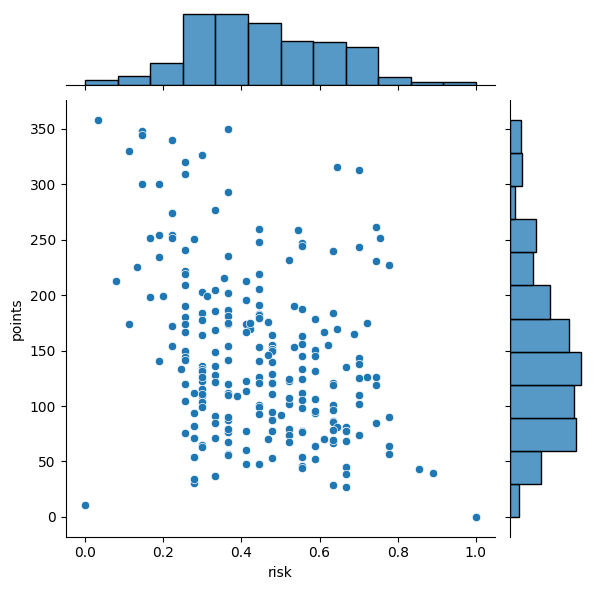

In [171]:
#plt.title("Correlation: Risk vs Points")
sns.jointplot(x=data['risk'], y=data['points'])

In [172]:
predictors = data.drop(['points', 'name', 'rank', 'team', 'outlook', 'position'], axis=1).columns
target = 'points'

X = data[predictors]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Predicting Points

Simple models to predict the number a points a player will score

In [173]:
def regressor_metrics(predictions: np.array, actuals: np.array) -> dict:
    """
    Calculates model performance 

    Arguments:
        predictions (np.array): Array of the model predictions.
        actuals (np.array): Array of the actual true values. 

    Returns:
        dict: Dictionary containing important regressor metrics.

    """
    
    
    r2 = r2_score(y_pred=predictions, y_true=actuals)
    rmse = np.sqrt(mean_squared_error(y_pred=predictions, y_true=actuals))
    mae = mean_absolute_error(y_pred=predictions, y_true=actuals)
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    }

In [174]:
model = LinearRegression()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = regressor_metrics(train_predictions, y_train)
test_metrics = regressor_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics)

print("Test Metrics")
print("=============\n", test_metrics)

Train Metrics
 {'r2': 0.6157337376869997, 'rmse': 46.99868003028528, 'mae': 31.664086625120316}
Test Metrics
 {'r2': 0.4613443673549613, 'rmse': 51.878441593546924, 'mae': 34.87823872192777}


In [175]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = regressor_metrics(train_predictions, y_train)
test_metrics = regressor_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics)

print("Test Metrics")
print("=============\n", test_metrics)

Train Metrics
 {'r2': 0.9682539484960412, 'rmse': 13.508725942415946, 'mae': 4.122579365079365}
Test Metrics
 {'r2': 0.1998709185530132, 'rmse': 63.22827690203174, 'mae': 37.047222222222224}


In [176]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = regressor_metrics(train_predictions, y_train)
test_metrics = regressor_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics)

print("Test Metrics")
print("=============\n", test_metrics)

Train Metrics
 {'r2': 0.917927438025064, 'rmse': 21.720435467943314, 'mae': 13.890317942176873}
Test Metrics
 {'r2': 0.5253052232885544, 'rmse': 48.7010747323584, 'mae': 31.17310387455907}


# Predicting Tier

Simple models to predict the tier a player should be in.

Checking the data-driven-ness of the footballers rankings

In [177]:
def classifier_metrics(predictions: np.array, actuals: np.array) -> list:
    """
    Calculates model performance 

    Arguments:
        predictions (np.array): Array of the model predictions.
        actuals (np.array): Array of the actual true values. 

    Returns:
        dict: List containing important classifier metrics.

    """
    
    cr = classification_report(y_pred=predictions, y_true=actuals)
    cm = confusion_matrix(y_pred=predictions, y_true=actuals)
    
    return (cr, cm)

In [178]:
predictors = data.drop(['points', 'name', 'rank', 'team', 'outlook', 'position', 'tier'], axis=1).columns
target = 'tier'

X = data[predictors]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [179]:
model = LogisticRegression()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = classifier_metrics(train_predictions, y_train)
test_metrics = classifier_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics[0])

print("Test Metrics")
print("=============\n", test_metrics[0])

Train Metrics
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.50      0.82      0.62        11
           3       1.00      0.09      0.17        11
           4       0.00      0.00      0.00        21
           5       0.32      0.45      0.37        29
           6       0.19      0.90      0.31        21
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        15

    accuracy                           0.25       168
   macro avg       0.18      0.21      0.13       168
weighted avg       0.18      0.25      0.15       168

Test Metrics
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00      

/Users/zachbloss/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/zachbloss/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/zachbloss/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with n

In [180]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = classifier_metrics(train_predictions, y_train)
test_metrics = classifier_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics[0])

print("Test Metrics")
print("=============\n", test_metrics[0])

Train Metrics
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        11
           3       0.92      1.00      0.96        11
           4       0.60      0.86      0.71        21
           5       0.86      0.83      0.84        29
           6       0.54      0.62      0.58        21
           7       0.58      0.65      0.61        17
           8       0.46      0.43      0.44        14
           9       0.58      0.44      0.50        16
          10       1.00      0.18      0.31        11
          11       0.53      0.53      0.53        15

    accuracy                           0.67       168
   macro avg       0.73      0.68      0.68       168
weighted avg       0.69      0.67      0.66       168

Test Metrics
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.50      0.43      0.46      

In [181]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_metrics = classifier_metrics(train_predictions, y_train)
test_metrics = classifier_metrics(test_predictions, y_test)

print("Train Metrics")
print("=============\n", train_metrics[0])

print("Test Metrics")
print("=============\n", test_metrics[0])

Train Metrics
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        11
           3       1.00      0.91      0.95        11
           4       0.74      0.81      0.77        21
           5       0.81      0.86      0.83        29
           6       0.54      0.62      0.58        21
           7       0.59      0.59      0.59        17
           8       0.71      0.36      0.48        14
           9       0.44      0.50      0.47        16
          10       1.00      0.18      0.31        11
          11       0.43      0.67      0.53        15

    accuracy                           0.67       168
   macro avg       0.75      0.68      0.68       168
weighted avg       0.71      0.67      0.66       168

Test Metrics
               precision    recall  f1-score   support

           2       0.25      0.33      0.29         3
           3       0.67      0.29      0.40      

<Figure size 1000x1000 with 0 Axes>

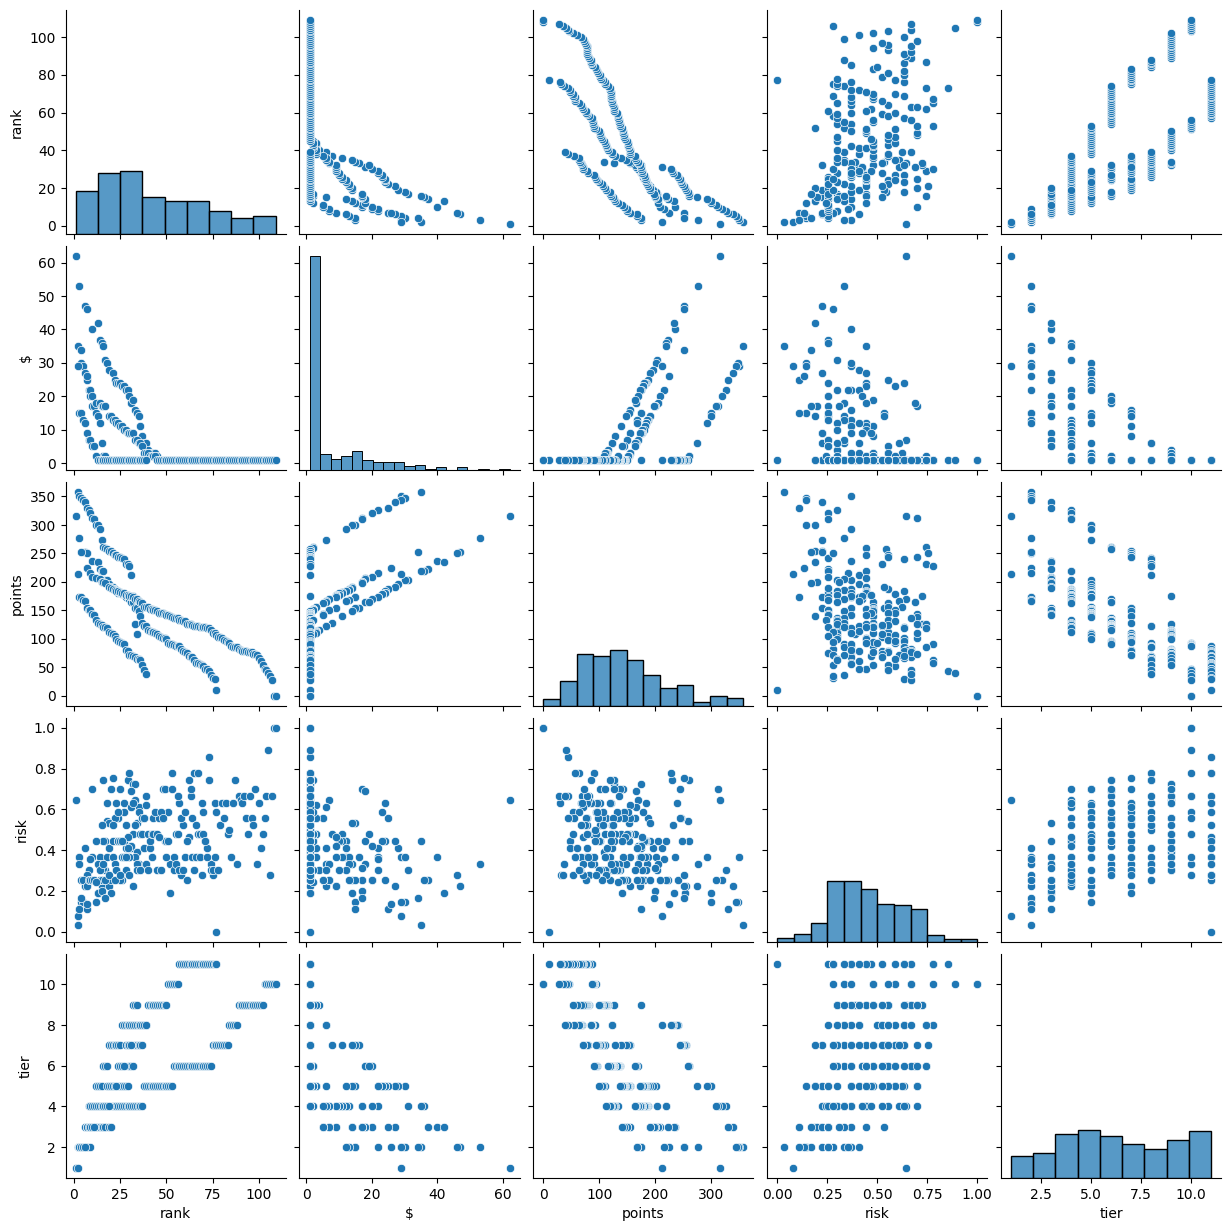

In [182]:
plt.figure(figsize=(10,10))
sns.pairplot(data)

In [183]:
data['points_per_dollar'] = data['points'] / data['$']

In [184]:
fig = px.scatter(
    data_frame=data,
    x='points_per_dollar',
    y='risk',
    color='position',
    symbol='position',
    title='Player Value vs Risk', 
    hover_data=['name', '$'],
)
plotly.offline.plot(fig, filename='../plots/points_per_dollar_vs_risk.html', auto_open=False)
fig.show()

In [185]:
fig = px.scatter(
    data_frame=data,
    x='points_per_dollar',
    y='tier',
    color='position',
    symbol='position',
    title='Player Value vs Risk', 
    hover_data=['name', '$', 'points'],
)
plotly.offline.plot(fig, filename='../plots/points_per_dollar_vs_tier.html', auto_open=False)
fig.show()

In [186]:
fig = px.scatter(
    data_frame=data,
    x='points_per_dollar',
    y='rank',
    color='position',
    symbol='position',
    title='Player Value vs Risk', 
    hover_data=['name', '$', 'points'],
)
plotly.offline.plot(fig, filename='../plots/points_per_dollar_vs_rank.html', auto_open=False)
fig.show()

In [187]:
fig = px.scatter_3d(
    data_frame=data,
    x='points_per_dollar',
    y='risk',
    z='points',
    color='position',
    symbol='position',
    title='Player Value vs Risk', 
    hover_data=['name', '$', 'points'],
)
plotly.offline.plot(fig, filename='../plots/player_value_vs_risk_3d_scatterplot.html', auto_open=False)
fig.show()

In [151]:
print("Top Value RBs (points / $ ADP")
data[
    data['position'] == 'RB'
][['name', '$', 'tier', 'points', 'points_per_dollar']].sort_values(by='points_per_dollar', ascending=False).head(20)

Top Value RBs (points / $ ADP


,name,$,tier,points,points_per_dollar
79,Kenneth Gainwell,1,9,105.7,105.7
80,Nyheim Hines,1,9,103.6,103.6
81,Gus Edwards,1,9,102.0,102.0
82,Isaiah Spiller,1,9,101.0,101.0
83,James Cook,1,9,99.4,99.4
84,Kenyan Drake,1,10,93.3,93.3
85,Alexander Mattison,1,10,91.1,91.1
86,James Robinson,1,10,90.3,90.3
87,Ronald Jones,1,10,88.9,88.9
88,Damien Williams,1,10,88.0,88.0


# Running Backs

Top Value Running Backs sorted by value-per-tier.

The `points_per_dollar` field is derived by dividing the projected points the player will score by their $ cost.

This table view aims to show the best value players in each tier.

In [155]:
data[
    data['position'] == 'RB'
][['name', '$', 'tier', 'points', 'points_per_dollar']].sort_values(by=['tier', 'points_per_dollar'], ascending=[True, False]).head(20)

,name,$,tier,points,points_per_dollar
34,Christian McCaffrey,62,1,315.5,5.088710
40,Alvin Kamara,46,2,251.1,5.458696
39,Dalvin Cook,47,2,251.9,5.359574
36,Austin Ekeler,53,2,276.7,5.220755
47,Nick Chubb,37,3,222.1,6.002703
43,Ezekiel Elliott,40,3,235.7,5.892500
46,Aaron Jones,42,3,234.4,5.580952
50,David Montgomery,31,4,203.2,6.554839
49,Saquon Barkley,35,4,219.3,6.265714
48,Javonte Williams,36,4,219.5,6.097222


# Wide Receivers

Top Value Wide Receivers sorted by value-per-tier.

In [156]:
data[
    data['position'] == 'WR'
][['name', '$', 'tier', 'points', 'points_per_dollar']].sort_values(by=['tier', 'points_per_dollar'], ascending=[True, False]).head(20)

,name,$,tier,points,points_per_dollar
119,Mike Williams,22,2,215.8,9.809091
117,Mike Evans,26,2,225.0,8.653846
114,Davante Adams,34,2,251.9,7.408824
129,Allen Robinson II,14,3,190.5,13.607143
130,Jaylen Waddle,14,3,190.0,13.571429
125,Keenan Allen,17,3,199.1,11.711765
126,A.J. Brown,17,3,199.1,11.711765
127,Brandin Cooks,17,3,198.3,11.664706
122,DJ Moore,18,3,205.9,11.438889
124,Courtland Sutton,18,3,205.0,11.388889


# Tight Ends

Top Value Tight Ends sorted by value-per-tier.

In [157]:
data[
    data['position'] == 'TE'
][['name', '$', 'tier', 'points', 'points_per_dollar']].sort_values(by=['tier', 'points_per_dollar'], ascending=[True, False]).head(20)

,name,$,tier,points,points_per_dollar
221,Travis Kelce,29,1,213.0,7.344828
225,George Kittle,12,2,166.9,13.908333
224,Darren Waller,13,2,167.2,12.861538
222,Dalton Schultz,15,2,173.9,11.593333
223,Kyle Pitts,15,2,173.8,11.586667
229,Cole Kmet,5,3,144.1,28.820000
230,Dawson Knox,5,3,141.3,28.260000
227,Dallas Goedert,7,3,150.0,21.428571
228,Zach Ertz,7,3,149.9,21.414286
226,T.J. Hockenson,9,3,154.2,17.133333


# Quarterbacks

Top Value Quarterbacks sorted by value-per-tier.

In [158]:
data[
    data['position'] == 'QB'
][['name', '$', 'tier', 'points', 'points_per_dollar']].sort_values(by=['tier', 'points_per_dollar'], ascending=[True, False]).head(20)

,name,$,tier,points,points_per_dollar
2,Kyler Murray,29,2,350.0,12.068966
4,Patrick Mahomes,29,2,344.1,11.865517
3,Jalen Hurts,30,2,348.0,11.600000
1,Justin Herbert,35,2,357.9,10.225714
6,Tom Brady,25,3,330.5,13.220000
5,Lamar Jackson,27,3,339.6,12.577778
9,Trey Lance,17,4,312.9,18.405882
10,Dak Prescott,17,4,309.6,18.211765
8,Joe Burrow,20,4,320.2,16.010000
7,Russell Wilson,22,4,326.5,14.840909
